In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
#from mcmodels.core.utils import 
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures, get_leaves_ontologicalorder, get_indices_2ormore, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation

In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)


annotation/ccf_2017


In [3]:
#load version 3 list
ontological_order = get_ordered_summary_structures(cache,167587189)
#due to redundancy in ccfv3, remove 'MDRNv', 'MDRNd' from summary structures (include as leafs of MDRN)
ontological_order[277]
ontological_order = np.setdiff1d(ontological_order, [1098, 1107])
#load version 2 list
#ontological_order = get_ordered_summary_structures(cache,687527945)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]

In [4]:
len(ontological_order)

313

In [5]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False, structure_set_id=167587189)

connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()


512
703
1089
1097
315
313
354
698
771
803
477
549


In [6]:
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs

# nexp = np.zeros(12)
# for i in range(12):
#     sid = major_structure_ids[i]
#     nexp[i] = len(leafs[sid])
# nexp.sum()
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#change ontological_order to ontologial_order_leaves for leaf targets

#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

In [9]:
connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

In [10]:
frac_learn = np.ones(12)
frac_learn[4] = .1
#sls = {}

In [263]:

def get_cre_distances(projections, means_cast, sids, cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = means_cast[sids[i]][cres[i]]#means_cast.loc[tuple([cres[i], sids[i]])]
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[i,j]  = np.linalg.norm(meani - meanj)#**2
    return(credist)

def get_loss_surface_cv_spline(projections, centroids, cres, sids,fraction):
    means_cast = get_means(projections, cres, sids)
    cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)
    surface = get_surface_from_distances_spline(projections,centroids,cre_distances_cv, fraction)
    surface.cre_distances_cv = cre_distances_cv
    return(surface)

def get_surface_from_distances_spline(projections,centroids,cre_distances, fraction):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2
    coordinates_normed[np.where(np.isnan(coordinates_normed))] = 0.
    #was n_splines = 10
    surface = LinearGAM(s(0, constraints=['monotonic_inc', 'concave'], n_splines=10) + 
                        s(1, constraints=['monotonic_inc', 'concave'], n_splines=10))

    #surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances
    return(surface)

def get_surface_from_distances_nw(projections,centroids,cre_distances, fraction, gamma = 100000):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2
    
    
    
    surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    #print(coordinates_normed[randos])
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances
    return(surface)

def get_means(projections, cres, sids):
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    return(cre_means)

def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = meani = means_cast[sids[i]][cres[i]]
        ls = np.where(sids == sids[i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                if cres[i] != cres[j]:
                    credist[j,i]  = np.linalg.norm(meanloocvi - meanj)
                else: 
                    credist[j,i] = 0.
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         #print(i)
#         meani = meani = means_cast[sids[i]][cres[i]]
#         ls = np.where(sids == sids[i])[0]
#         crs = np.where(cres == cres[i])[0]
#         ncr = len(np.intersect1d(ls, crs))
        
#         meanloocvi = meani
#         if ncr > 1:
#             meanloocvi = (meani - (1/ ncr) * proj[i]) * (ncr / (ncr - 1))#(ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
#         else:
#             meanloocvi = np.zeros(proj[i].shape[0])
#             meanloocvi[:] = np.nan
            
#         for j in range(nsamp):
#             meanj = means_cast[sids[j]][cres[j]]
#             if sids[j] == sids[i]:
#                 if cres[i] != cres[j]:
#                     credist[j,i]  = np.linalg.norm(meanloocvi - meanj)
#                     #print('here',i,j,credist[j,i])
#                 else: 
#                     credist[j,i] = 0.
#                     #print('he',i,j,credist[j,i])
                    
    return(credist)

def get_embedding_cv(surface, dists, cre_distances_cv):
    
    ntrain = dists.shape[0]
    norms = surface.norms
    norms[np.where(norms == 0.)] = 1.
    leaf_pairs = np.asarray(np.where(~np.isnan(cre_distances_cv))).transpose()
    nlp = leaf_pairs.shape[0]
    
    losses = np.zeros((ntrain, ntrain))
    for i in range(nlp):
        d_ij = dists[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[0]
        p_ij = cre_distances_cv[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[1]
        losses[leaf_pairs[i][0]][leaf_pairs[i][1]] = surface.predict(np.asarray([[d_ij, p_ij]]))
      
    losses[np.where(losses == 0)] = np.nan
    
    return(losses)


from mcmodels.core import Mask


def get_embedding(surface, dists, cres = None, cre = None, means = None):
    
    ntrain = dists.shape[0]
    neval = dists.shape[1]
    norms = surface.norms
    #cnorm = surface.cnorm
    
    cre_deezy = np.zeros((ntrain))
    
    for i in range(ntrain):
        cre_deezy[i] = np.linalg.norm(means[cres[i]] - means[cre])
    
    losses = np.zeros((ntrain, neval))
    for i in range(ntrain):
        for j in range(neval):
            d_ij = dists[i,j] / norms[0]
            p_i = cre_deezy[i] / norms[1]
            losses[i,j] = surface.predict(np.asarray([[d_ij, p_i]]))
            
    return(losses)



def get_nw_predictions(projections, dists, gamma):
  
     
    projections = np.asarray(projections, dtype=np.float32)
    neval = dists.shape[1]
    #nexp = centroids.shape[0]
    predictions = np.zeros((neval, projections.shape[1]))
    predictions[:] = np.nan
    
    #print(model_index_val.shape, eval_index_val.shape)
    #weights = np.exp(- dists / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
    for i in range(neval):
        dists_i = dists[:,i] - np.min(dists[:,i])
        #dists_i = dists[i,:] - np.min(dists[i,:])
        weights_i = np.exp(- dists_i * gamma)
        weights_i = np.asarray(weights_i, dtype=np.float32)
        weights_i[np.isnan(weights_i)] = 0.
        weights_i = weights_i / np.sum(weights_i)
        predictions[i] = np.dot(weights_i, projections)
        
    return(predictions) 

def get_connectivity_matrices2_nw(connectivity_data, gamma_dict, cres, structures, model_ordering, source_ordering, target_ordering, eval_cres, cre_model = True):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(eval_cres)

    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = model_ordering[i,0]#structure_major_dictionary[source_ordering[i]]
            gamma = gamma_dict[sid]
            connectivity[c,i] = get_region_prediction2(cache,
                                                      connectivity_data.structure_datas[sid],
                                                      exp_structures = structures[sid],
                                                      model_region = model_ordering[i,1],
                                                      prediction_region= source_ordering[i],
                                                      cre = eval_cres[c],
                                                      gamma = gamma_dict[sid],
                                                      cre_model = cre_model)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)


def get_region_prediction2(cache, structure_data,  exp_structures, model_region, prediction_region, cre, gamma, surface = None, cre_model = False):
    
    model_experiments = np.where(exp_structures == model_region)[0]
    nexp = len(model_experiments)
    
    cres = structure_data.crelines[model_experiments]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

#     if surface != None and cre_model != True:
#         means = get_means(projections,cres, np.repeat(model_region,nexp))
        
#         losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
#         predictions = get_nw_predictions(projections, losses, gamma)
#         output = np.mean(predictions, axis = 0)
        
    if surface != None and cre_model == True:
        projections = structure_data.reg_proj_norm[model_experiments]
        centroids = structure_data.centroids[model_experiments]
        means = get_means(projections, cres, np.repeat(model_region,nexp))
        #print(means)
        print(prediction_region, model_region,means.keys())
        #supposed to check if theres a cre in that region
        if np.isin(model_region, list(means.keys())):
            if np.isin(cre, np.asarray(list(means[model_region].keys()))):
                losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
                predictions = get_nw_predictions(projections, losses, gamma)
                output = np.mean(predictions, axis = 0)
            else:
                output = np.zeros(projections.shape[1])
                output[:] = np.nan
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan           
#     if surface == None and cre_model != True:
#         means = get_means(projections, cres, [model_region])
#         predictions = means[cres]
#         output = np.mean(predictions, axis = 0)
        
    if surface == None and cre_model == True:
        
        
        modelcre_experiments = np.where(cres == cre)[0]
        if len(modelcre_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments][modelcre_experiments]
            centroids = structure_data.centroids[model_experiments][modelcre_experiments]
            #print((pairwise_distances(centroids, mask.coordinates)**2).shape)
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
            
    if surface == None and cre_model == False:
        
        if len(model_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments]
            centroids = structure_data.centroids[model_experiments]
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
        
    return(output)


#good one
#model_ordering_leafs,model_region_structures are len n exps, which model to use
#model_experiments_leaf,model_experiments_structure are inds of 
def get_connectivity_matrices3(connectivity_data, surfaces, cres, structures_smooth,structures_surface, model_ordering_leafs, model_ordering_surfaces, source_ordering, target_ordering, eval_cres):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(eval_cres)

    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = model_ordering_leafs[i,0]#structure_major_dictionary[source_ordering[i]]
            gamma = surfaces[sid].gamma#gamma_dict[sid]
            connectivity[c,i] = get_region_prediction3(cache,
                                                      connectivity_data.structure_datas[sid],
                                                      #structures_sid = structures[sid],
                                                       structures_surface_sid =structures_surface[sid],
                                                       structures_smooth_sid= structures_smooth[sid],
                                                      model_region_leaf = model_ordering_leafs[i,1],
                                                       model_region_surface = model_ordering_surfaces[i,1],
                                                      prediction_region= source_ordering[i],
                                                      cre = eval_cres[c],
                                                      gamma = surfaces[sid].bestgamma,
                                                      surface = surfaces[sid],
                                                      cre_model = True)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)

def get_region_prediction3(cache, structure_data,  structures_surface_sid,structures_smooth_sid, model_region_surface, model_region_leaf, prediction_region, cre, gamma, surface = None, cre_model = False):
    

    model_experiments_leaf = np.where(structures_smooth_sid == model_region_leaf)[0]
    model_experiments_surface = np.where(structures_surface_sid == model_region_surface)[0]
    
    nexp_surface = len(model_experiments_surface)
    
    cres_surface = structure_data.crelines[model_experiments_surface]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)
    if surface != None and cre_model == True:
        projections = structure_data.reg_proj_norm[model_experiments_leaf]
        projections_surface = structure_data.reg_proj_norm[model_experiments_surface]
        centroids = structure_data.centroids[model_experiments_leaf]#model_region_leaf
        means = get_means(projections_surface, cres_surface, np.repeat(model_region_surface,nexp_surface))
        #supposed to check if theres a cre in that region
        #if np.isin(model_region_surface, list(means.keys())):
        if centroids.shape[0]>0:
            if np.isin(cre, np.asarray(list(means[model_region_surface].keys()))):
                losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres_surface, cre, means[model_region_surface])
                predictions = get_nw_predictions(projections, losses, gamma)
                output = np.mean(predictions, axis = 0)
            else:
                output = np.zeros(projections.shape[1])
                output[:] = np.nan
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan
    if surface == None and cre_model == True:
        
        
        modelcre_experiments = np.where(cres == cre)[0]
        if len(modelcre_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments][modelcre_experiments]
            centroids = structure_data.centroids[model_experiments][modelcre_experiments]
            #print((pairwise_distances(centroids, mask.coordinates)**2).shape)
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
            
    if surface == None and cre_model == False:
        
        if len(model_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments]
            centroids = structure_data.centroids[model_experiments]
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
        
    return(output)


In [234]:
summary_structures = {}

for sid in major_structure_ids:
    summary_structures[sid] = connectivity_data.structure_datas[sid].summary_structures
    
connectivity_data.summary_structures = summary_structures#get_indices_2ormore(connectivity_data.leafs)


In [264]:
from pygam import LinearGAM,PoissonGAM, te, s, f
for m in range(12):
    print(m)
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv_str = get_loss_surface_cv_spline(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 connectivity_data.creline[sid],
                                                                                                 connectivity_data.summary_structures[sid],
                                                                                                 frac_learn[m])

0
1


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


did not converge
2


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


3


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


4


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


5


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


6


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


7


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


8
9


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


10


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


11


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


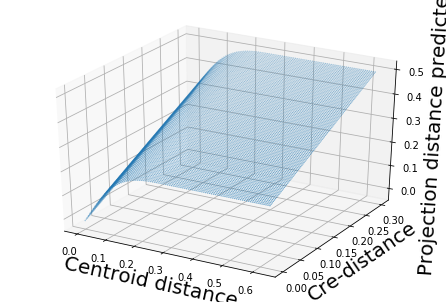

In [237]:
plot_loss_surface(connectivity_data.structure_datas[512].loss_surface_cv_str)

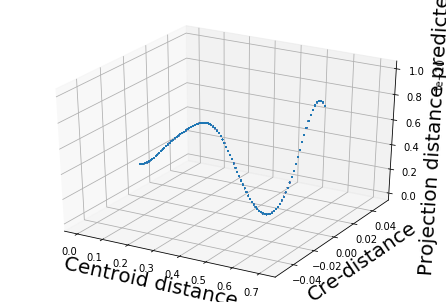

In [238]:
plot_loss_surface(connectivity_data.structure_datas[703].loss_surface_cv_str)

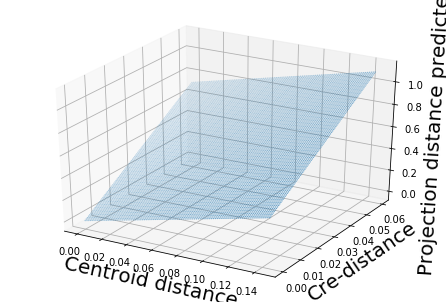

In [239]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[2]].loss_surface_cv_str)

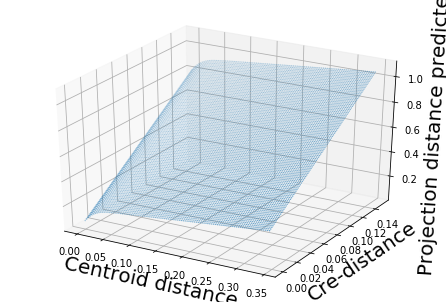

In [240]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[3]].loss_surface_cv_str)

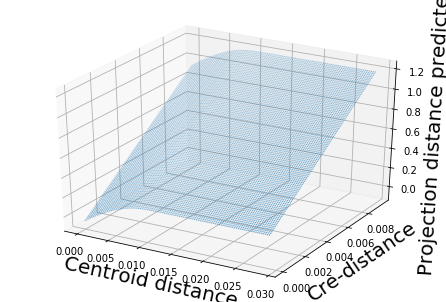

In [241]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv_str)

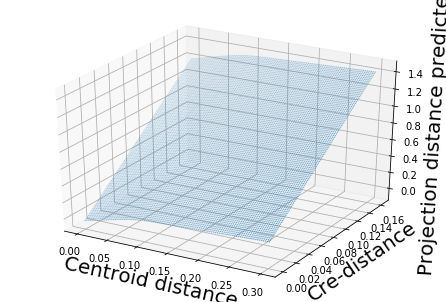

In [242]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[5]].loss_surface_cv_str)

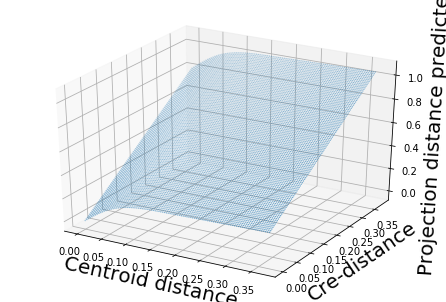

In [243]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[6]].loss_surface_cv_str)

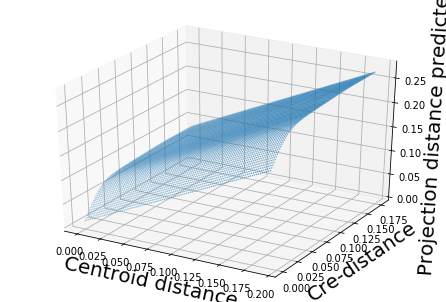

In [244]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[7]].loss_surface_cv_str)

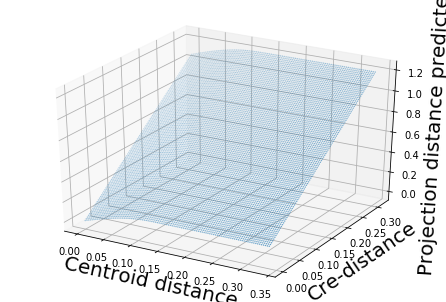

In [245]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[8]].loss_surface_cv_str)

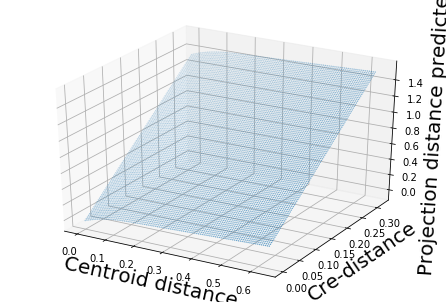

In [246]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[9]].loss_surface_cv_str)

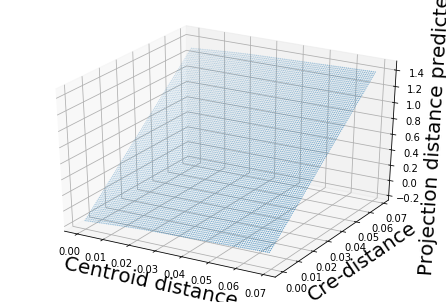

In [247]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[10]].loss_surface_cv_str)

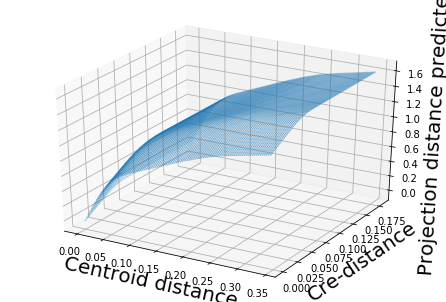

In [248]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[11]].loss_surface_cv_str)

In [265]:
for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    print(m)
    connectivity_data.structure_datas[sid].smoothed_losses_str = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv_str,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv_str.cre_distances_cv)

0
1
2
3
4
5
6
7
8
9
10
11


In [266]:
twostage_leaf_creleaf2 = Crossval()

#gammas = np.asarray([0.1,.5,1,2,10,20,40,100,1000,10000])
gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])
#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses_str,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.leaf2_index_matrices[sid], 
                                                                                       connectivity_data.leaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
            
    
    
a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))

twostage_leaf_creleaf2.loocvpredictions = loocvpredictions

twostage_leaf_creleaf2.losses = get_loss(reg_proj_norm, twostage_leaf_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
twostage_leaf_creleaf2.bestgamma  = get_best_hyperparameters(twostage_leaf_creleaf2.losses,keys)
twostage_leaf_creleaf2.meanloss = get_loss_best_hyp(twostage_leaf_creleaf2.losses, twostage_leaf_creleaf2.bestgamma)


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


In [267]:
#old cre-dist_cv
twostage_leaf_creleaf2.meanloss

array([0.03623069, 0.4970684 , 0.09623128, 0.23899943, 0.1386334 ,
       0.11940649, 0.18722318, 0.05942767, 0.23649906, 0.19054358,
       0.06130229, 0.3031755 ])

In [262]:
twostage_leaf_creleaf2.meanloss

array([0.04719432, 0.4970684 , 0.09685805, 0.24186465, 0.14160384,
       0.11949102, 0.18278866, 0.05925518, 0.23618288, 0.18628311,
       0.06020692, 0.30796261])

In [ ]:
#earlier (i.e. after surface switch but before )
array([0.04185842, 0.4970684 , 0.0871666 , 0.22092905, 0.12534084,
       0.12002594, 0.15506002, 0.05769648, 0.22862465, 0.14679975,
       0.04871583, 0.29453529])
#nw 
array([0.04951837, 0.4970684 , 0.10898734, 0.26110819, 0.1509602 ,
       0.11951267, 0.22278944, 0.07451032, 0.23860635, 0.19459881,
       0.06375954, 0.57273508])

#firstpostzack
array([0.03862558, 0.4966726 , 0.08387246, 0.21983532, 0.12718922,
       0.11226157, 0.16358549, 0.05566028, 0.22811406, 0.13767042,
       0.04806401, 0.32689735])

#from the uggha (spliney problems)
array([0.04184946, 0.4966726 , 0.08045654, 0.2192497 , 0.12431989,
       0.11991531, 0.15813113, 0.05768053, 0.22860475, 0.14659473,
       0.04867287, 0.29429855])

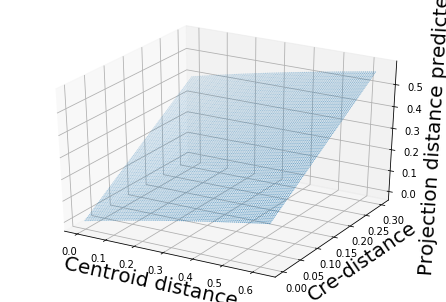

In [212]:
plot_loss_surface(connectivity_data.structure_datas[512].loss_surface_cv_str)

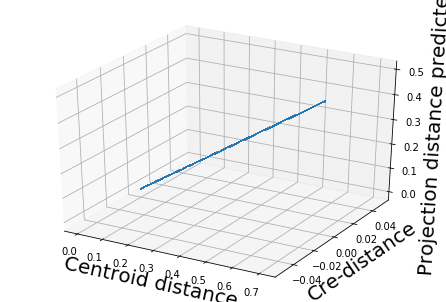

In [213]:
plot_loss_surface(connectivity_data.structure_datas[703].loss_surface_cv_str)

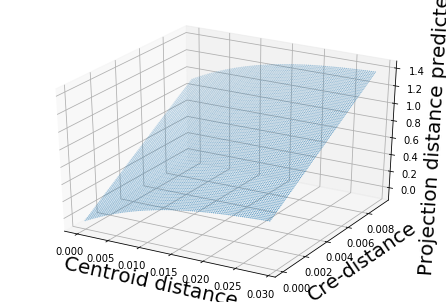

In [214]:
plot_loss_surface(connectivity_data.structure_datas[315].loss_surface_cv_str)

In [78]:
major_structure_ids[:2]

[512, 703]

In [249]:
sids = connectivity_data.summary_structures[512]
cres=  connectivity_data.creline[512]
projections = connectivity_data.structure_datas[512].reg_proj_norm
print(cres[np.where(sids == 91)[0]])

['C57BL/6J' 'Gpr26-Cre_KO250' 'Ntsr1-Cre_GN220']


In [250]:
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    proj = projections
    means_cast = cre_means
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = means_cast[sids[i]][cres[i]]
        ls = np.where(sids==sids[i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            #meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
            meanloocvi = (meani - (1/ ncr) * proj[i]) * (ncr / (ncr - 1))#results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                if cres[i] != cres[j]:
                    credist[j,i]  = np.linalg.norm(meanloocvi - meanj)
                    #print('here',i,j,credist[j,i])
                else: 
                    #if i != j:
                        #print('asfasadf',i,j)
                    credist[j,i] = 0.

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


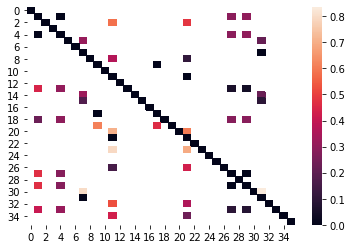

In [251]:
sns.heatmap(credist)

In [252]:
    centroids = connectivity_data.structure_datas[512].centroids
    cre_distances = credist
    fraction = 1.
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2
    
    surface = LinearGAM(s(0, constraints=['monotonic_inc', 'concave'], n_splines=4) + 
                        s(1, constraints=['monotonic_inc', 'concave'], n_splines=4))

    #surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
#     surface.fit(coordinates_normed[randos], projection_distances[randos])
#     surface.coordinates_normed = coordinates_normed
    surface.fit(coordinates[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances

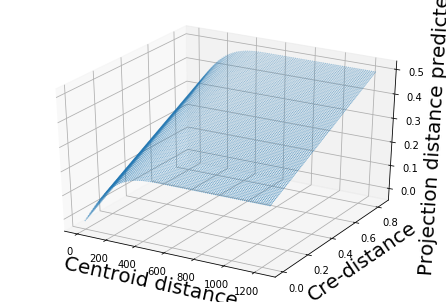

In [220]:
plot_loss_surface(surface) #10

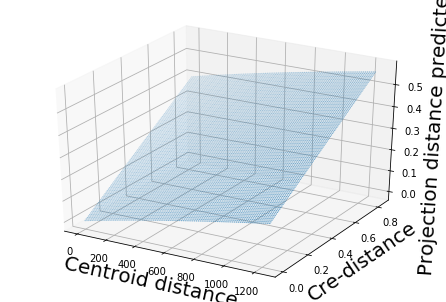

In [222]:
plot_loss_surface(surface) #4

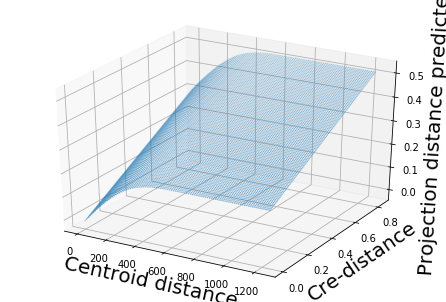

In [224]:
plot_loss_surface(surface) #7

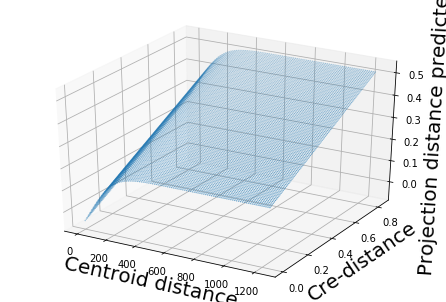

In [118]:
plot_loss_surface(surface)

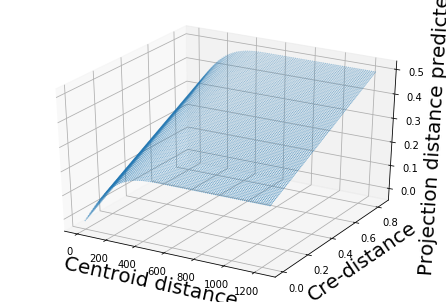

In [85]:
plot_loss_surface(surface)

In [225]:

sids = connectivity_data.summary_structures[703]
cres=  connectivity_data.creline[703]
projections = connectivity_data.structure_datas[703].reg_proj_norm
#print(cres[np.where(sids == 91)[0]])

In [226]:
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    proj = projections
    means_cast = cre_means
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = means_cast[sids[i]][cres[i]]
        ls = np.where(sids==sids[i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            #meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
            meanloocvi = (meani - (1/ ncr) * proj[i]) * (ncr / (ncr - 1))#results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                if cres[i] != cres[j]:
                    print(i,j)
                    credist[j,i]  = np.linalg.norm(meanloocvi - meanj)
                    #print('here',i,j,credist[j,i])
                else: 
                    #if i != j:
                    print('asfasadf',i,j)
                    credist[j,i] = 0.

asfasadf 0 0
0 6
asfasadf 1 1
asfasadf 2 2
2 4
asfasadf 3 3
asfasadf 3 5
4 2
asfasadf 4 4
asfasadf 5 3
asfasadf 5 5
6 0
asfasadf 6 6


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [227]:
cres

array(['Cux2-IRES-Cre', 'Rbp4-Cre_KL100', 'Dlg3-Cre_KG118',
       'Gnb4-IRES2-Cre', 'C57BL/6J', 'Gnb4-IRES2-Cre',
       'Ppp1r17-Cre_NL146'], dtype=object)

In [228]:
sids

array([131, 780, 295, 583, 295, 583, 131], dtype=object)

In [229]:
credist

array([[ 0., nan, nan, nan, nan, nan, nan],
       [nan,  0., nan, nan, nan, nan, nan],
       [nan, nan,  0., nan, nan, nan, nan],
       [nan, nan, nan,  0., nan,  0., nan],
       [nan, nan, nan, nan,  0., nan, nan],
       [nan, nan, nan,  0., nan,  0., nan],
       [nan, nan, nan, nan, nan, nan,  0.]])

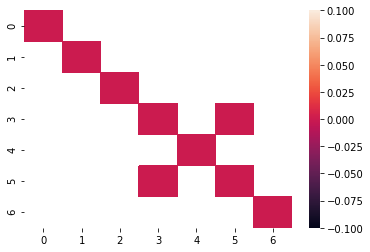

In [230]:
sns.heatmap(credist)

In [153]:
#get_surface_from_distances_spline(projections,centroids,cre_distances, 1.)

In [231]:
    fraction = 1.
    cre_distances = credist
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2
    coordinates_normed[np.where(np.isnan(coordinates_normed))] = 0.
    
    surface = LinearGAM(s(0, constraints=['monotonic_inc', 'concave'], n_splines=7) + 
                        s(1, constraints=['monotonic_inc', 'concave'], n_splines=7))

    #surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


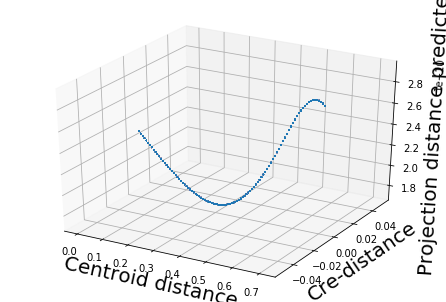

In [232]:
plot_loss_surface(surface)

In [160]:
    surface2 = LinearGAM(s(0, constraints=['monotonic_inc', 'concave'], n_splines=10), max_iter = 5000)
    surface2.fit(coordinates_normed[randos][:,:1], projection_distances[randos])

did not converge


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=5000, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

In [ ]:
surface2.p

In [156]:
projection_distances

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.49706839],
       [0.        ],
       [0.49706839],
       [0.        ],
       [0.        ]])

In [177]:
coordinates_normed

array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.70710678, 0.        ],
       [0.        , 0.        ],
       [0.70710678, 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ]])

In [157]:
coordinates

array([[  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [755.58175157,   0.        ],
       [  0.        ,   0.        ],
       [755.58175157,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ]])

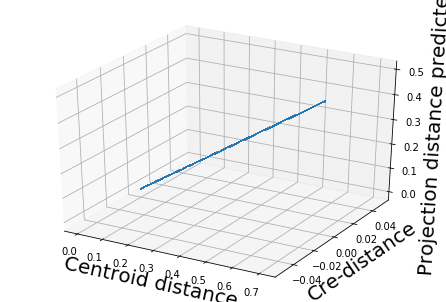

In [187]:
plot_loss_surface(surface)

In [164]:
surface = LinearGAM(s(0, constraints=['monotonic_inc', 'concave'], n_splines = 4))

In [167]:
surface.fit(coordinates_normed[randos][:,:1], projection_distances[randos])

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

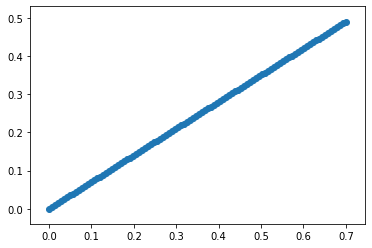

In [169]:
plt.scatter(np.linspace(0,.7,100), surface.predict(np.linspace(0,.7,100)))

In [181]:
surface = LinearGAM(s(0, constraints=['monotonic_inc', 'concave'], n_splines=4) + 
                   s(1, constraints=['monotonic_inc', 'concave'], n_splines=4))

surface.fit(coordinates_normed[randos][:,:], projection_distances[randos])

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)

In [182]:
outies = surface.predict(np.asarray([np.linspace(0,.7,100), np.zeros(100)]).transpose())

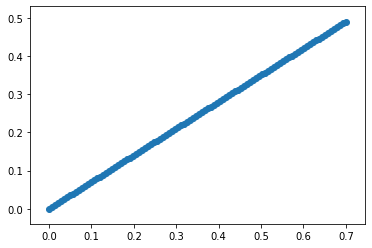

In [183]:
plt.scatter(np.linspace(0,.7,100), outies)

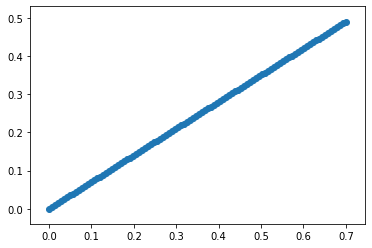

In [176]:
plt.scatter(np.linspace(0,.7,100), outies)

In [185]:
outies = surface.predict(np.asarray([np.linspace(0,.7,100), np.zeros(100)]).transpose())

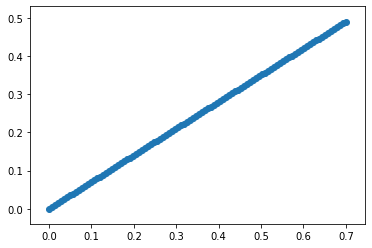

In [186]:
plt.scatter(np.linspace(0,.7,100), outies)

In [101]:
surface = get_surface_from_distances_spline(projections,centroids,credist, 1.)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


ValueError: X data must not contain Inf nor NaN

In [92]:
 cres,sids

(array(['Cux2-IRES-Cre', 'Rbp4-Cre_KL100', 'Dlg3-Cre_KG118',
        'Gnb4-IRES2-Cre', 'C57BL/6J', 'Gnb4-IRES2-Cre',
        'Ppp1r17-Cre_NL146'], dtype=object),
 array([131, 780, 295, 583, 295, 583, 131], dtype=object))

In [53]:
     means_cast = get_means(projections, cres, sids)
     cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)
     surface = get_surface_from_distances_spline(projections,centroids,cre_distances_cv, fraction)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


ValueError: X data must not contain Inf nor NaN

In [54]:
cre_distances_cv

array([[ 0., nan, nan, nan, nan, nan, nan],
       [nan,  0., nan, nan, nan, nan, nan],
       [nan, nan,  0., nan, nan, nan, nan],
       [nan, nan, nan,  0., nan,  0., nan],
       [nan, nan, nan, nan,  0., nan, nan],
       [nan, nan, nan,  0., nan,  0., nan],
       [nan, nan, nan, nan, nan, nan,  0.]])

In [ ]:
def get_surface_from_distances_spline(projections,centroids,cre_distances, fraction):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2
    
    surface = LinearGAM(s(0, constraints=['monotonic_inc', 'concave'], n_splines=10) + 
                        s(1, constraints=['monotonic_inc', 'concave'], n_splines=10))

    #surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances
    return(surface)


In [59]:
def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = meani = means_cast[sids[i]][cres[i]]
        ls = np.where(sids == sids[i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                if cres[i] != cres[j]:
                    credist[j,i]  = np.linalg.norm(meanloocvi - meanj)
                else: 
                    credist[j,i] = 0.
    return(credist)

In [60]:
get_cre_distances_cv(proj, means_cast, sids,cres)

array([[ 0., nan, nan, nan, nan, nan, nan],
       [nan,  0., nan, nan, nan, nan, nan],
       [nan, nan,  0., nan, nan, nan, nan],
       [nan, nan, nan,  0., nan,  0., nan],
       [nan, nan, nan, nan,  0., nan, nan],
       [nan, nan, nan,  0., nan,  0., nan],
       [nan, nan, nan, nan, nan, nan,  0.]])

In [61]:
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = means_cast[sids[i]][cres[i]]
        ls = np.where(sids==sids[i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            #meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
            meanloocvi = (meani - (1/ ncr) * proj[i]) * (ncr / (ncr - 1))#results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[j,i]  = np.linalg.norm(meanloocvi - meanj)


In [62]:
credist

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan, 0.35251539,        nan,
        0.35251539,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan, 0.35251539,        nan,
        0.35251539,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan]])

In [73]:
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = meani = means_cast[sids[i]][cres[i]]
        ls = np.where(sids == sids[i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (meani - (1/ ncr) * proj[i]) * (ncr / (ncr - 1))#(ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                if cres[i] != cres[j]:
                    credist[j,i]  = np.linalg.norm(meanloocvi - meanj)
                    print('here',i,j,credist[j,i])
                else: 
                    credist[j,i] = 0.
                    print('he',i,j,credist[j,i])

he 0 0 0.0
here 0 6 nan
he 1 1 0.0
he 2 2 0.0
here 2 4 nan
he 3 3 0.0
he 3 5 0.0
here 4 2 nan
he 4 4 0.0
he 5 3 0.0
he 5 5 0.0
here 6 0 nan
he 6 6 0.0


In [72]:
credist

array([[ 0., nan, nan, nan, nan, nan, nan],
       [nan,  0., nan, nan, nan, nan, nan],
       [nan, nan,  0., nan, nan, nan, nan],
       [nan, nan, nan,  0., nan,  0., nan],
       [nan, nan, nan, nan,  0., nan, nan],
       [nan, nan, nan,  0., nan,  0., nan],
       [nan, nan, nan, nan, nan, nan,  0.]])

In [65]:
cres

array(['Cux2-IRES-Cre', 'Rbp4-Cre_KL100', 'Dlg3-Cre_KG118',
       'Gnb4-IRES2-Cre', 'C57BL/6J', 'Gnb4-IRES2-Cre',
       'Ppp1r17-Cre_NL146'], dtype=object)

In [66]:
sids

array([131, 780, 295, 583, 295, 583, 131], dtype=object)

In [257]:
for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    print(m)
    connectivity_data.structure_datas[sid].smoothed_losses_str = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv_str,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv_str.cre_distances_cv)

0
1


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in double_scalars


ValueError: X data must not contain Inf nor NaN

In [254]:
class Crossval:
    
    def __init__(self):
        2+2

In [255]:
connectivity_data.creleaf2_evalindices = get_eval_indices(connectivity_data.creleaf2_index_matrices)

In [210]:
twostage_leaf_creleaf2 = Crossval()

#gammas = np.asarray([0.1,.5,1,2,10,20,40,100,1000,10000])
gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])
#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses_str,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.leaf2_index_matrices[sid], 
                                                                                       connectivity_data.leaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
            
    
    
a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))

twostage_leaf_creleaf2.loocvpredictions = loocvpredictions

twostage_leaf_creleaf2.losses = get_loss(reg_proj_norm, twostage_leaf_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
twostage_leaf_creleaf2.bestgamma  = get_best_hyperparameters(twostage_leaf_creleaf2.losses,keys)
twostage_leaf_creleaf2.meanloss = get_loss_best_hyp(twostage_leaf_creleaf2.losses, twostage_leaf_creleaf2.bestgamma)


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


In [211]:
twostage_leaf_creleaf2.meanloss 

array([0.04075189, 0.4970684 , 0.08653271, 0.22092905, 0.12355493,
       0.11706742, 0.15506002, 0.05769648, 0.22862465, 0.14679975,
       0.04871583, 0.2961187 ])

In [24]:
twostage_leaf_creleaf2.meanloss 

array([0.04185842, 0.4970684 , 0.0871666 , 0.22092905, 0.12452633,
       0.12002594, 0.15506002, 0.05769648, 0.22862465, 0.14679975,
       0.04871583, 0.29453529])

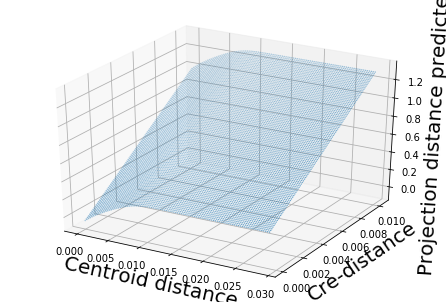

In [213]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv_str)

In [60]:
#row_multi_ind = #np.vstack([cre_inds,summary_comb,layers])
row_multi_ind = np.asarray([['Expected-loss'],['Leaf'],['Summary Structure']])
row_multi_ind_tuples = list(zip(*row_multi_ind))
cname = pd.MultiIndex.from_tuples(row_multi_ind_tuples , names=['Estimator','Smoothing','Target'])

In [ ]:
nexps = np.zeros(12, dtype = int)
for i in range(12):
    nexps[i] = len(connectivity_data.creleaf2_evalindices[major_structure_ids[i]])

In [62]:
#row_multi_ind = #np.vstack([cre_inds,summary_comb,layers])
other_multi_ind = np.asarray([major_structures,nexps])
other_multi_ind_tuples = list(zip(*other_multi_ind))
rname = pd.MultiIndex.from_tuples(other_multi_ind_tuples , names=['Structure','# Eval exps'])

In [64]:
output = pd.DataFrame(twostage_leaf_creleaf2.meanloss, columns =cname , index = rname)

In [65]:
output

Estimator                 Expected-loss
Smoothing                          Leaf
Target                Summary Structure
Structure # Eval exps                  
CB        4                    0.041858
CTXsp     2                    0.497068
HPF       62                   0.087167
HY        41                   0.220929
Isocortex 732                  0.124526
MB        18                   0.120026
MY        7                    0.155060
OLF       17                   0.057696
P         8                    0.228625
PAL       11                   0.146800
STR       45                   0.048716
TH        29                   0.294535

In [66]:
output.to_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/results/twostage_leaf_summary.csv')

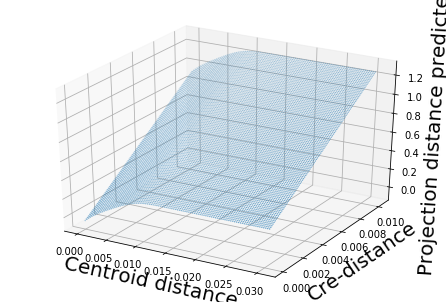

In [25]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv_str)

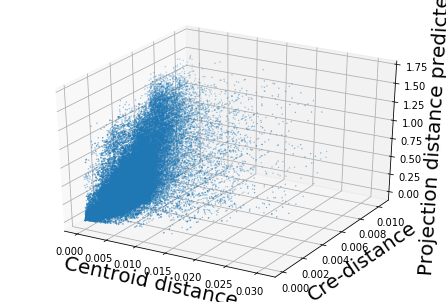

In [50]:
plot_loss_scatter(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv_str)

In [77]:

def plot_loss_model(surface):
    xs = np.linspace(0, surface.coordinates_normed[:,0].max(), 100)
    ys = np.linspace(0, surface.coordinates_normed[:,1].max(), 100)
    preds = np.empty((100,100))
    for x in range(100):
        for y in range(100):
            preds[x,y] = surface.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))

    mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

    #%matplotlib inline
    fig = plt.figure()
    ax = Axes3D(fig)

    ax.scatter(surface.coordinates_normed[:, 0],
               surface.coordinates_normed[:, 1],
               surface.projection_distances[:, 0], s=.2, alpha = .03)

    ax.scatter(mxy[:,:,0],
               mxy[:,:,1],
               preds, s= .1)

    ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
    ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
    ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

    #ax.set_axis_off()
    ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
    ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
    ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)


def plot_loss_scatter(loss_surface):
    fig = plt.figure()
    ax = Axes3D(fig)

    # ax.scatter(msvds[sid].projection_mask.coordinates[:,0],
    #            msvds[sid].projection_mask.coordinates[:,1],
    #            msvds[sid].projection_mask.coordinates[:,2], alpha = .01, s = .1)

    ax.scatter(loss_surface.coordinates_normed[:, 0],
               loss_surface.coordinates_normed[:, 1],
               loss_surface.projection_distances[:, 0], s=.1)
    ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
    ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
    ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)


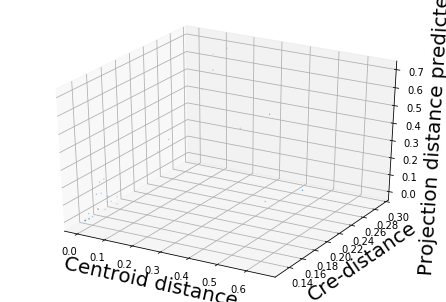

In [81]:
plot_loss_scatter(connectivity_data.structure_datas[major_structure_ids[0]].loss_surface_cv_str)

In [82]:
coordinates_normed = connectivity_data.structure_datas[major_structure_ids[0]].loss_surface_cv_str.coordinates_normed
projection_distances = connectivity_data.structure_datas[major_structure_ids[0]].loss_surface_cv_str.projection_distances


In [125]:
# surface = LinearGAM(s(0, constraints=['monotonic_inc', 'concave'], n_splines=10,spline_order=1) + 
#                     s(1, constraints=['monotonic_inc', 'concave'], n_splines=10,spline_order=1),lam=0.,fit_intercept = False,max_iter = 1000,tol = 1e-10,verbose = True)

# surface = LinearGAM(s(1, constraints=['monotonic_inc', 'concave'], n_splines=2,spline_order=1)
#                     ,lam=0.,fit_intercept = True,max_iter = 1000,tol = 1e-10,verbose = True)

surface = LinearGAM(s(0, constraints=['monotonic_inc', 'concave'], n_splines=2,spline_order=1)
                    ,lam=0.,fit_intercept = True,max_iter = 1000,tol = 1e-10,verbose = True)


fraction  = 1.
#fraction = .1
ngp = coordinates_normed.shape[0]
#surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
surface.fit(coordinates_normed[randos][:,1], projection_distances[randos])
surface.coordinates_normed = coordinates_normed
#surface.norms = np.linalg.norm(coordinates, axis = 0)
surface.projection_distances = projection_distances

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/pygam/utils.py:113: UserWarning: Expected 2D input data array, but found 1D. Expanding to 2D.
  warnings.warn(msg)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


In [122]:
#plt.scatter(coordinates_normed[randos][:,0],projection_distances[randos])
#           
           
#           , projection_distances[randos]

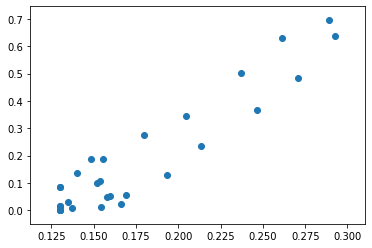

In [123]:
plt.scatter(coordinates_normed[randos][:,1],projection_distances[randos])

array(['C57BL/6J', 'Gpr26-Cre_KO250', 'Ntsr1-Cre_GN220'], dtype=object)

In [214]:
sids = connectivity_data.leafs[512]
cres=  connectivity_data.creline[512]
projections = connectivity_data.structure_datas[512].reg_proj_norm
print(cres[np.where(sids == 91)[0]])

['C57BL/6J' 'Gpr26-Cre_KO250' 'Ntsr1-Cre_GN220']


In [215]:
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [216]:
proj = projections
means_cast = cre_means

In [245]:
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = means_cast[sids[i]][cres[i]]
        ls = np.where(sids==sids[i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            #meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
            meanloocvi = (meani - (1/ ncr) * proj[i]) * (ncr / (ncr - 1))#results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[j,i]  = np.linalg.norm(meanloocvi - meanj)


In [243]:
np.linalg.norm(meani - ((proj[11] +  proj[21] ) / 2))

0.0

In [246]:
np.linalg.norm(meanloocvi - meanj)

nan

In [252]:
np.linalg.norm(proj[11]),np.linalg.norm(proj[21])

(1.0, 0.9999999999999998)

In [239]:
np.linalg.norm(proj[11] - proj[21])

0.28931493246445206

In [254]:
np.intersect1d(ls, crs), np.where(credist ==  np.nanmin(credist))[0], credist[11,21], credist[21,11]

(array([11, 21]), array([ 7, 31]), 0.14465746623222606, 0.144657466232226)

In [247]:
i = 11
#print(i)
meani = means_cast[sids[i]][cres[i]]
ls = np.where(sids == sids[i])[0]
crs = np.where(cres == cres[i])[0]
ncr = len(np.intersect1d(ls, crs))

meanloocvi = meani
if ncr > 1:
    meanloocvi = (meani - (1/ ncr) * proj[i]) * (ncr / (ncr - 1)) #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
else:
    meanloocvi = np.zeros(proj[i].shape[0])
    meanloocvi[:] = np.nan

j = 21
meanj = means_cast[sids[j]][cres[j]]
if sids[j] == sids[i]:
    credist[j,i]  = np.linalg.norm(meanloocvi - meanj)


In [257]:
(meanloocvi - proj[21]).max()

1.1102230246251565e-16

In [255]:
ncr

2

In [251]:
np.linalg.norm(meanj)

0.9894817923859297

In [249]:
np.linalg.norm(meanloocvi - meanj)*2

0.289314932464452

In [ ]:
plt.scatter()

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


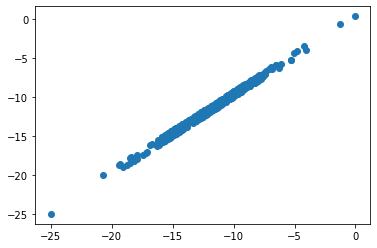

In [234]:
plt.scatter(np.log(meanj), np.log(meanloocvi))

In [221]:
meanloocvi

array([2.05007500e-04, 1.28215343e-02, 5.69917189e-06, 7.76497530e-07,
       0.00000000e+00, 7.83355252e-05, 8.36094447e-06, 2.00777709e-09,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.49576467e-05,
       3.55349758e-06, 6.08468084e-05, 0.00000000e+00, 2.44308922e-06,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.28609418e-06, 0.00000000e+00,
       4.61491682e-04, 8.20707455e-05, 6.44245305e-05, 1.00004644e-04,
       2.92289223e-04, 0.00000000e+00, 4.87902989e-05, 0.00000000e+00,
       0.00000000e+00, 1.17757379e-04, 9.41526858e-06, 0.00000000e+00,
       1.49732327e-04, 2.10923174e-07, 0.00000000e+00, 0.00000000e+00,
       9.94462494e-05, 0.00000000e+00, 0.00000000e+00, 3.68917571e-08,
       3.88549231e-07, 0.00000000e+00, 3.56834982e-06, 5.26461823e-05,
       7.92384353e-05, 7.92647796e-07, 7.93894461e-07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.02653867e-06, 2.55108940e-06,
      

In [196]:
np.nanmin(credist) #this is the cre-distance of two that are the same.... but howww?????? and why so .5 ish??

0.4999999999999999

In [195]:
print(cres[11],cres[21], np.where(cres == cres[11]),np.where(cres == cres[21]))
print(sids[11],sids[21], np.where(sids == sids[11]),np.where(sids == sids[21]))

C57BL/6J C57BL/6J (array([ 0,  3,  9, 11, 17, 21, 22, 24, 27, 29, 30, 35]),) (array([ 0,  3,  9, 11, 17, 21, 22, 24, 27, 29, 30, 35]),)
1091 1091 (array([ 2,  8, 11, 20, 21, 23, 26, 32, 34]),) (array([ 2,  8, 11, 20, 21, 23, 26, 32, 34]),)


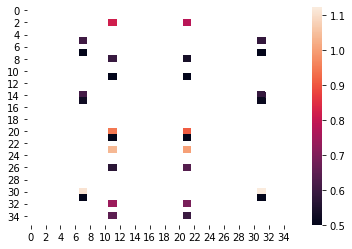

In [179]:
sns.heatmap(credist)

In [189]:
credist

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [187]:
    centroids = connectivity_data.structure_datas[512].centroids
    cre_distances = credist
    fraction = 1.
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2
    
    surface = LinearGAM(s(0, constraints=['monotonic_inc', 'concave'], n_splines=10) + 
                        s(1, constraints=['monotonic_inc', 'concave'], n_splines=10))

    #surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
#     surface.fit(coordinates_normed[randos], projection_distances[randos])
#     surface.coordinates_normed = coordinates_normed
    surface.fit(coordinates[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances

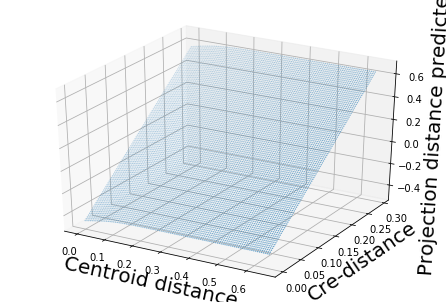

In [183]:
plot_loss_surface(surface)

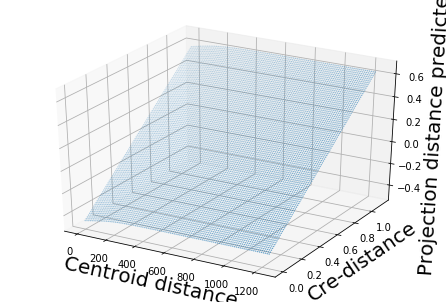

In [188]:
plot_loss_surface(surface)

In [ ]:
def plot_loss_surface(surface):
    xs = np.linspace(0, surface.coordinates_normed[:,0].max(), 100)
    ys = np.linspace(0, surface.coordinates_normed[:,1].max(), 100)
    preds = np.empty((100,100))
    for x in range(100):
        for y in range(100):
            preds[x,y] = surface.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))

    mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

    #%matplotlib inline
    fig = plt.figure()
    ax = Axes3D(fig)

    ax.scatter(mxy[:,:,0],
               mxy[:,:,1],
               preds, s= .1)

    #ax.set_axis_off()
    ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
    ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
    ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)



In [170]:
    m = 0
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv_str = get_loss_surface_cv_spline(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 connectivity_data.creline[sid],
                                                                                                 connectivity_data.summary_structures[sid],
                                                                                                 frac_learn[m])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


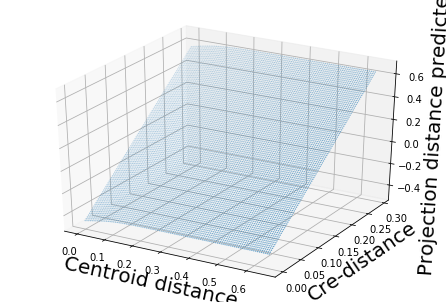

In [171]:
plot_loss_surface(connectivity_data.structure_datas[sid].loss_surface_cv_str)

In [185]:
    m = 0
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv = get_loss_surface_cv_spline(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 connectivity_data.creline[sid],
                                                                                                 connectivity_data.leafs[sid],
                                                                                                 frac_learn[m])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


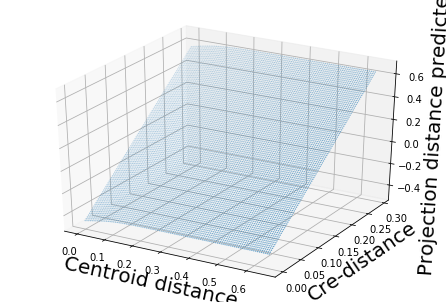

In [186]:
plot_loss_surface(connectivity_data.structure_datas[sid].loss_surface_cv)

In [ ]:

def get_surface_from_distances_spline(projections,centroids,cre_distances, fraction):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2
    
    surface = LinearGAM(s(0, constraints=['monotonic_inc', 'concave'], n_splines=10) + 
                        s(1, constraints=['monotonic_inc', 'concave'], n_splines=10))

    #surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances
    return(surface)

In [142]:
#cre_means[91]['Gpr26-Cre_KO250']

In [ ]:
#why does it not go to zero in cre-distance anywhere???
def get_means(projections, cres, sids):
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    return(cre_means)

def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = meani = means_cast[sids[i]][cres[i]]
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[j,i]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)

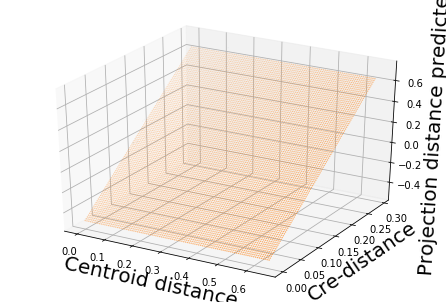

In [124]:
plot_loss_model(surface)

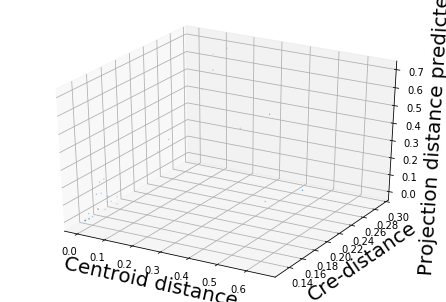

In [99]:
plot_loss_scatter(surface)

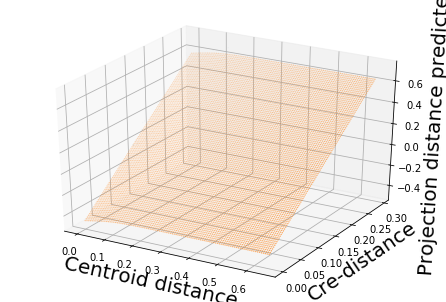

In [83]:
plot_loss_model(connectivity_data.structure_datas[major_structure_ids[0]].loss_surface_cv_str)

0
1
2
3
4
5
6
7
8
9
10
11


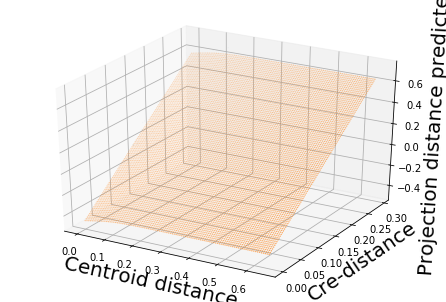

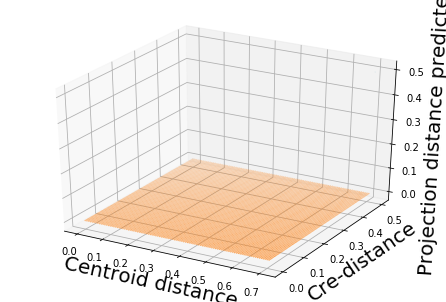

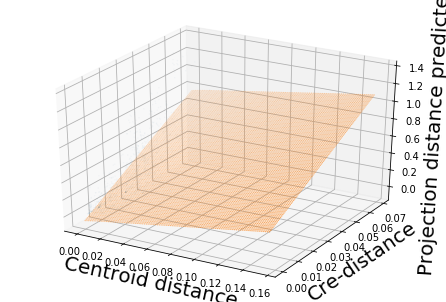

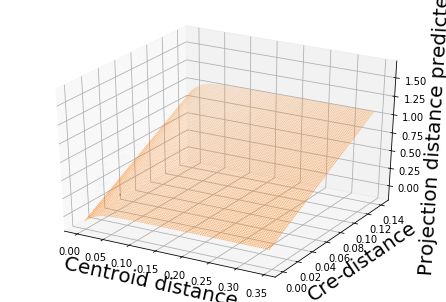

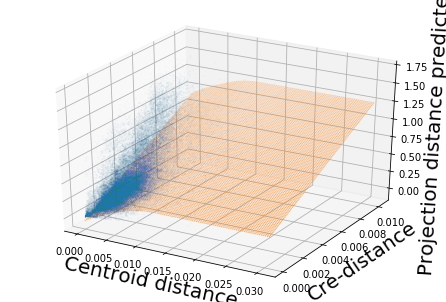

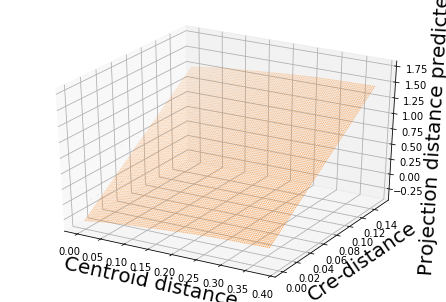

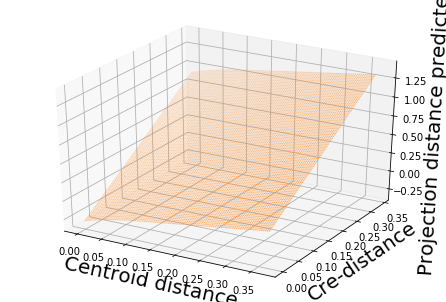

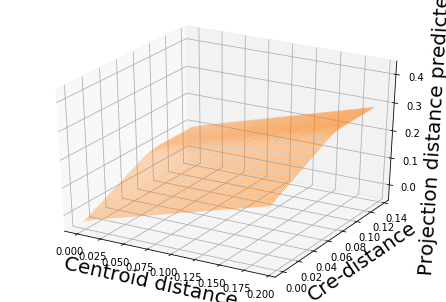

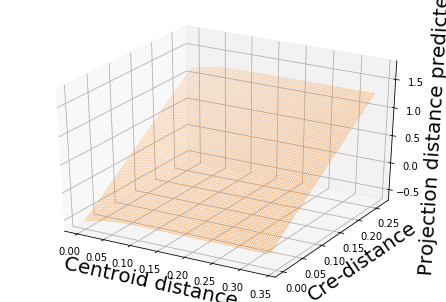

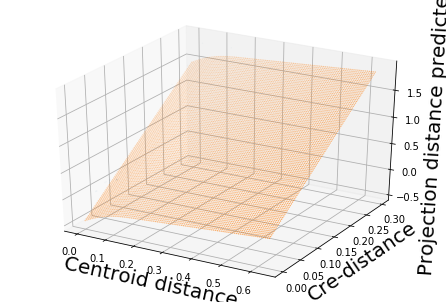

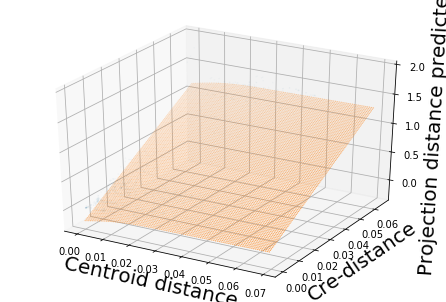

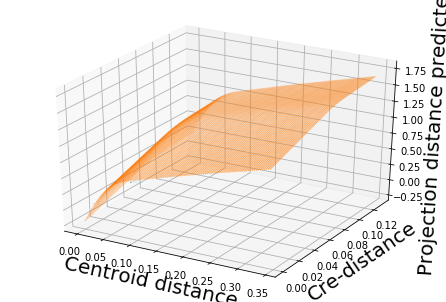

In [79]:
for i in range(12):
    print(i)
    plot_loss_model(connectivity_data.structure_datas[major_structure_ids[i]].loss_surface_cv_str)
    plt.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/results/el_model' + str(i))

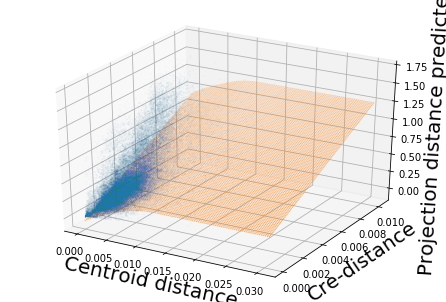

In [78]:
plot_loss_model(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv_str)

In [33]:
surface = LinearGAM(s(0, constraints=['monotonic_inc', 'concave'], n_splines=10) + 
                    s(1, constraints=['monotonic_inc', 'concave'], n_splines=10))

fraction = .1
ngp = coordinates_normed.shape[0]
#surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
surface.fit(coordinates_normed[randos], projection_distances[randos])
surface.coordinates_normed = coordinates_normed
#surface.norms = np.linalg.norm(coordinates, axis = 0)
surface.projection_distances = projection_distances

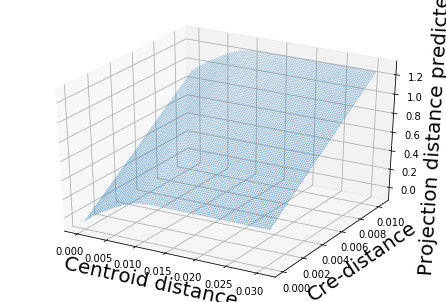

In [34]:
plot_loss_surface(surface)

In [37]:
surface = LinearGAM(s(0, constraints=['monotonic_inc', 'concave'], n_splines=4) + 
                    s(1, constraints=['monotonic_inc', 'concave'], n_splines=4))

fraction = .1
ngp = coordinates_normed.shape[0]
#surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
surface.fit(coordinates_normed[randos], projection_distances[randos])
surface.coordinates_normed = coordinates_normed
#surface.norms = np.linalg.norm(coordinates, axis = 0)
surface.projection_distances = projection_distances

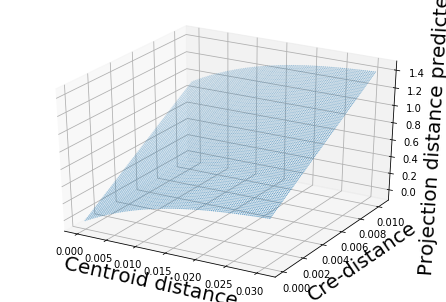

In [38]:
plot_loss_surface(surface)

In [48]:
surface = LinearGAM(s(0, constraints=['monotonic_inc', 'concave'], n_splines=10,spline_order=1) + 
                    s(1, constraints=['monotonic_inc', 'concave'], n_splines=10,spline_order=1),lam=0.)

fraction = .1
ngp = coordinates_normed.shape[0]
#surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
surface.fit(coordinates_normed[randos], projection_distances[randos])
surface.coordinates_normed = coordinates_normed
#surface.norms = np.linalg.norm(coordinates, axis = 0)
surface.projection_distances = projection_distances

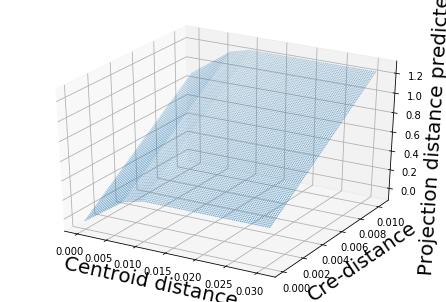

In [49]:
plot_loss_surface(surface)

In [26]:
coordinates_normed = connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv_str.coordinates_normed
projection_distances = connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv_str.projection_distances


In [192]:
#np.save('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/results/twostage_leaf_creleaf',twostage_leaf_creleaf2.meanloss)

In [ ]:
#was .158 cortex 1077 first time

In [57]:
#twostage_leaf_creleaf2 = Crossval()

pds = {}
for sid in major_structure_ids:
    pds[sid] = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    
#gammas = np.asarray([0.1,.5,1,2,10,20,40,100,1000,10000])
gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])
#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    print(sid)
    #print(connectivity_data.structure_datas[sid].reg_proj_norm.shape)
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    #pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    print('here')
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm[:,:], 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses_str,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds[sid],                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.creleaf2_index_matrices[sid], 
                                                                                       connectivity_data.creleaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])

512
here
703
here
1089
here
1097
here
315
here
313
here
354
here
698
here
771
here
803
here
477
here
549
here


In [61]:

reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    
a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))
nw_creleaf_creleaf2 = Crossval()
nw_creleaf_creleaf2.loocvpredictions = loocvpredictions
nw_creleaf_creleaf2.losses = get_loss(reg_proj_norm, nw_creleaf_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
nw_creleaf_creleaf2.bestgamma  = get_best_hyperparameters(nw_creleaf_creleaf2.losses,keys)
nw_creleaf_creleaf2.meanloss = get_loss_best_hyp(nw_creleaf_creleaf2.losses, nw_creleaf_creleaf2.bestgamma)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

In [67]:
twostage_leaf_creleaf2.meanloss

array([0.04185842, 0.4970684 , 0.0871666 , 0.22092905, 0.12534084,
       0.12002594, 0.15506002, 0.05769648, 0.22862465, 0.14679975,
       0.04871583, 0.29453529])

In [62]:
nw_creleaf_creleaf2.meanloss

array([0.04951837, 0.4970684 , 0.10898734, 0.26110819, 0.1509602 ,
       0.11951267, 0.22278944, 0.07451032, 0.23860635, 0.19459881,
       0.06375954, 0.57273508])

In [80]:
error_nw = nw_creleaf_creleaf2.loocvpredictions[315][nw_creleaf_creleaf2.bestgamma[4][0]] - reg_proj_norm[315]

error_2s = twostage_leaf_creleaf2.loocvpredictions[315][nw_creleaf_creleaf2.bestgamma[4][0]] - reg_proj_norm[315]

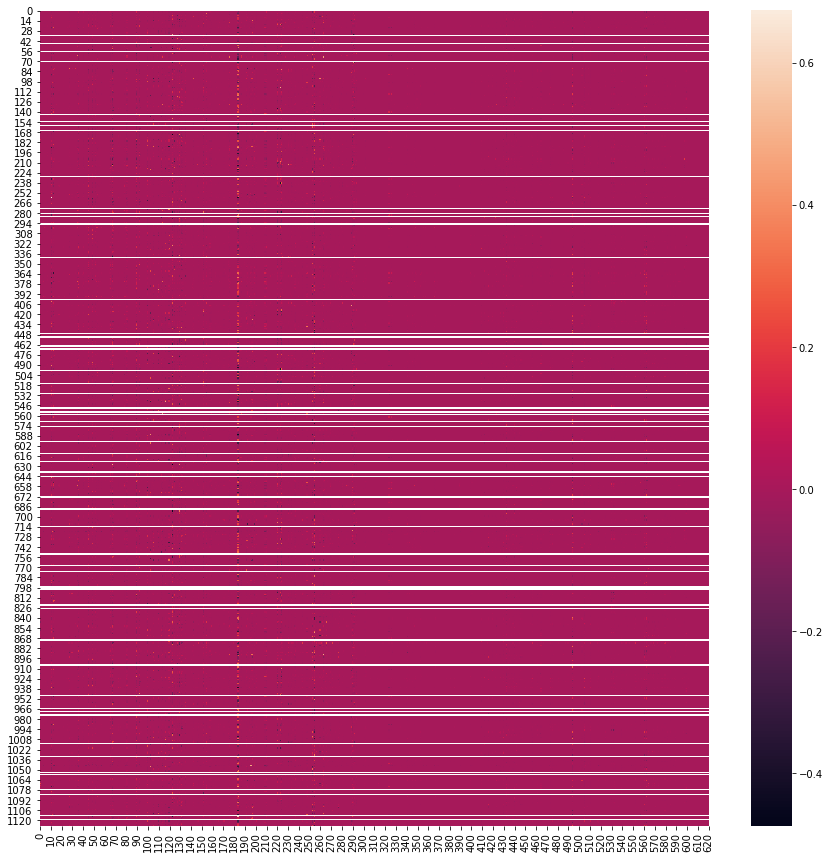

In [92]:
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(error_nw - error_2s)

In [148]:
ords =np.nansum(error_nw - error_2s, axis = 1).argsort()

In [161]:
improve = np.nansum(error_nw - error_2s, axis = 1)

In [170]:
np.nansum(error_nw**2, axis = 1).max()

1.1534393517974788

In [172]:
np.nansum(error_2s**2, axis = 1).max()

0.9270653141277441

In [173]:
errors_nwsum = np.nansum(error_nw**2, axis = 1)
errors_2ssum = np.nansum(error_2s**2, axis = 1)

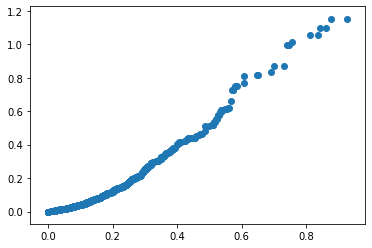

In [174]:
plt.scatter(errors_2ssum[errors_2ssum.argsort()],errors_nwsum[errors_nwsum.argsort()])

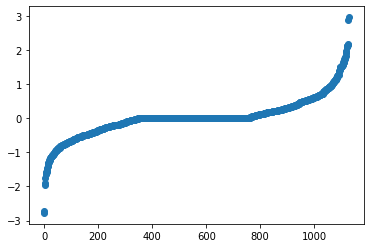

In [150]:
plt.scatter(range(1128), improve[ords])

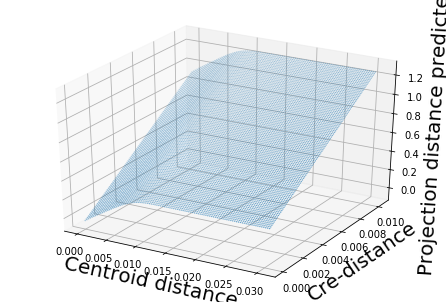

In [185]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv_str)

In [188]:
major_structures

['CB',
 'CTXsp',
 'HPF',
 'HY',
 'Isocortex',
 'MB',
 'MY',
 'OLF',
 'P',
 'PAL',
 'STR',
 'TH']

In [190]:
connectivity_data.structure_datas[major_structure_ids[11]].loss_surface_cv_str.predict([[0,0]])

array([-0.19494716])

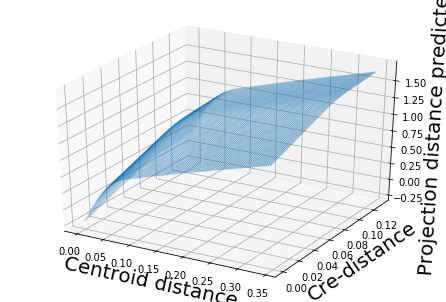

In [187]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[11]].loss_surface_cv_str)

In [164]:
#connectivity_data.creline[315][np.where(improve > .5)[0]]

In [165]:
#[ia_map[improv_leaf[i]] for i in range(len(improv_leaf))]

In [178]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi


In [180]:
# df = pd.DataFrame({
# 'group': ['A','B'],
# 'var1': [38, 1.5, 30, 4],
# 'var2': [29, 10, 9, 34],
# 'var3': [8, 39, 23, 24],
# 'var4': [7, 31, 33, 14],
# 'var5': [28, 15, 32, 14]
# })
df_loss = pd.DataFrame([twostage_leaf_creleaf2.meanloss,
nw_creleaf_creleaf2.meanloss])
df_loss.columns = major_structures
df.index = ['Expected-loss','NW']

0         1         2         3         4         5         6  \
0  0.041858  0.497068  0.087167  0.220929  0.125341  0.120026  0.155060   
1  0.049518  0.497068  0.108987  0.261108  0.150960  0.119513  0.222789   

          7         8         9        10        11  
0  0.057696  0.228625  0.146800  0.048716  0.294535  
1  0.074510  0.238606  0.194599  0.063760  0.572735

In [182]:
# df = pd.DataFrame({
# 'group': ['A','B','C','D'],
# 'var1': [38, 1.5, 30, 4],
# 'var2': [29, 10, 9, 34],
# 'var3': [8, 39, 23, 24],
# 'var4': [7, 31, 33, 14],
# 'var5': [28, 15, 32, 14]
# })
 
 
 
# # ------- PART 1: Create background
 
# # number of variable
# categories=list(df)[1:]
# N = len(categories)
 
# # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
# angles = [n / float(N) * 2 * pi for n in range(N)]
# angles += angles[:1]
 
# # Initialise the spider plot
# ax = plt.subplot(111, polar=True)
 
# # If you want the first axis to be on top:
# ax.set_theta_offset(pi / 2)
# ax.set_theta_direction(-1)
 
# # Draw one axe per variable + add labels labels yet
# plt.xticks(angles[:-1], categories)
 
# # Draw ylabels
# ax.set_rlabel_position(0)
# plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
# plt.ylim(0,40)
 
 
# # ------- PART 2: Add plots
 
# # Plot each individual = each line of the data
# # I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# # Ind1
# values=df.loc[0].drop('group').values.flatten().tolist()
# values += values[:1]
# ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
# ax.fill(angles, values, 'b', alpha=0.1)
 
# # Ind2
# values=df.loc[1].drop('group').values.flatten().tolist()
# values += values[:1]
# ax.plot(angles, values, linewidth=1, linestyle='solid', label="group B")
# ax.fill(angles, values, 'r', alpha=0.1)
 
# # Add legend
# plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
# #PREVIOUS POST
# #390 Basic radar chart


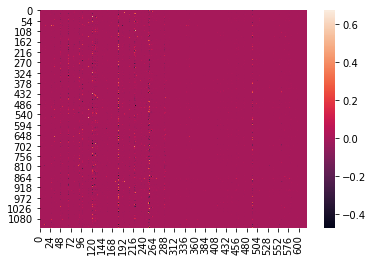

In [245]:
sns.heatmap(error_nw - error_2s)

In [262]:
improve[np.where(connectivity_data.creline[315] == 'C57BL/6J')[0]].sum()

61.92732299822053

In [256]:
improve.shape

(1128,)

In [258]:
improve = np.nansum(error_nw - error_2s, axis = 1)

In [261]:
improve.sum()

32.43908523243155

In [263]:
error_2s.mean()

nan